## Data preprocessing 

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def standardization(df, cols):
    scaler = StandardScaler()
    df[cols] = scaler.fit_transform(df[cols])

def data_prep():
    # Read txt
    train_df = pd.read_csv('traininingdata.txt', sep=";")
    test_df = pd.read_csv('testdata.txt', sep=";")

    # Find 3 kinds of attributes
    numeric_var = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
    binary_var = ['default', 'housing', 'loan', 'y']
    categorical_var = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

    # Replace the pdays -1 with maximized pdays
    max_pdays_train = max(train_df['pdays'])
    max_pdays_test = max(test_df['pdays'])
    max_pdays = max(max_pdays_train, max_pdays_test)
    train_df['pdays'] = train_df['pdays'].replace({-1: max_pdays})
    test_df['pdays'] = test_df['pdays'].replace({-1: max_pdays})

    # Replace labels Yes and No with 1 and 0
    train_df = train_df.replace({'yes': 1, 'no': 0})
    test_df = test_df.replace({'yes': 1, 'no': 0})

    # Split data to train and test parts
    x_train = train_df.iloc[:, :-1]
    y_train = train_df.iloc[:, -1]
    x_test = test_df.iloc[:, :-1]
    y_test = test_df.iloc[:, -1]

    # Transfrom categorical attributes with one-hot encoding 
    x_train = pd.get_dummies(x_train)
    x_test = pd.get_dummies(x_test)
    # Find the columns that in x_train but not in x_test
    missing_cols = set(x_train.columns) - set(x_test.columns)
    for c in missing_cols:
        x_test[c] = 0
    # Ensure the column order of x_train and x_test are the same
    x_test = x_test[x_train.columns]

    # Standarize numerical attributes
    standardization(x_train, numeric_var)
    standardization(x_test, numeric_var)

    return x_train, y_train, x_test, y_test

if __name__ == "__main__":
    x_train, y_train, x_test, y_test = data_prep()
    print(x_train.shape)## Data preprocessing 

(36168, 48)


## SVM

In [5]:
x_train, y_train, x_test, y_test = data_prep()

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef
import seaborn as sns

Here we define some reusable functions for hyper-parameter tuning:

In [7]:
# visualize the GridSearchCV results
def visualize_cv(best_svc, score, num):
    # create df storing model scores ordered by performance
    results_df = pd.DataFrame(best_svc.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_score"])[:num]
    results_df = results_df.set_index(
        results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
    ).rename_axis("kernel")
    results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

    # 1. plot top 'num' models between cv fold and scores  
    model_split_scores = results_df.filter(regex=r"split\d*_test_score")
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    sns.lineplot(
        data=model_split_scores.transpose(),
        dashes=False,
        palette="Set1",
        marker="o",
        alpha=0.5,
        ax=ax[0],
    )
    ax[0].set_xlabel("CV test fold", size=12, labelpad=10)
    ax[0].set_ylabel(f"Model {score} Score", size=12)
    
    # 2. plot avg test score to each params combination
    model_test_score = results_df.filter(regex="mean_test_score")
    print(model_test_score)
    sns.lineplot(
        data=model_test_score,
        dashes=False,
        palette="Set1",
        marker="o",
        alpha=0.5,
        ax=ax[1],
    )
    ax[1].set_xlabel("Params", size=12, labelpad=10)
    ax[1].set_ylabel(f"Mean model {score} Score", size=12)
    ax[1].tick_params(labelrotation=25)
    plt.show()
    
    return results_df
    

In [12]:
# test models with top parameters
def test_models(top_params, x_train, y_train, x_test, y_test):
    f1_scores_list = {}
    for param in top_params:
        print(param)
        kernel = param['kernel']
        gamma = param['gamma']
        C = param['C']
        
        SVC_clf = model = SVC(kernel=kernel, C=C, gamma=gamma, probability=True)
        SVC_clf.fit(x_train, y_train)
        y_pred = SVC_clf.predict(x_test)

        cm = confusion_matrix(y_test,y_pred)
        TP = cm[1,1]
        FP = cm[1,0]
        FN = cm[0,1]
        TN = cm[0,0]
        accuracy = (TP+TN)/np.sum(cm)
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        F1 = (2 * precision * recall)/(precision + recall)
        f1_scores_list[f'{kernel}_{C}_{gamma}'] = [F1]
    
    tmp_df = pd.DataFrame(f1_scores_list)
    tmp_df.index = ['Test F1 score']
    test_results_df = tmp_df.transpose().rename_axis("kernel").sort_values(by=["Test F1 score"], ascending=False)
    print(test_results_df)
    
    fig, ax = plt.subplots()
    sns.lineplot(
        data=test_results_df,
        dashes=False,
        palette="Set1",
        marker="o",
        alpha=0.5,
        ax=ax,
    )
    ax.set_xlabel("Params", size=12, labelpad=10)
    ax.set_ylabel(f"Test F1 Score", size=12)
    ax.tick_params(labelrotation=25)
    plt.show()

**Find optimized hyper-parameters(Metric: F1):**

Note: the below gridsearch may take several hours! Use load functions below to load prepared 'best_svc' result.

In [4]:
Only use "load" for loading pre-saved resultsimport warnings
warnings.filterwarnings("ignore")

params = {'kernel': ['rbf', 'poly', 'sigmoid'], 
          'gamma' : [1e-1, 1e-2, 1e-3], 
          'C'     : [1e-2, 1e-1, 1, 10, 100]}

svc_test = SVC(kernel='rbf', probability=True) 
best_svc = GridSearchCV(svc_test, param_grid=params, cv=3, verbose=10, scoring='f1')
best_svc.fit(x_train,y_train)
best_svc.best_params_

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV 1/3; 1/45] START C=0.01, gamma=0.1, kernel=rbf..............................
[CV 1/3; 1/45] END C=0.01, gamma=0.1, kernel=rbf;, score=0.000 total time= 2.0min
[CV 2/3; 1/45] START C=0.01, gamma=0.1, kernel=rbf..............................
[CV 2/3; 1/45] END C=0.01, gamma=0.1, kernel=rbf;, score=0.000 total time= 1.9min
[CV 3/3; 1/45] START C=0.01, gamma=0.1, kernel=rbf..............................
[CV 3/3; 1/45] END C=0.01, gamma=0.1, kernel=rbf;, score=0.000 total time= 2.0min
[CV 1/3; 2/45] START C=0.01, gamma=0.1, kernel=poly.............................
[CV 1/3; 2/45] END C=0.01, gamma=0.1, kernel=poly;, score=0.201 total time= 1.3min
[CV 2/3; 2/45] START C=0.01, gamma=0.1, kernel=poly.............................
[CV 2/3; 2/45] END C=0.01, gamma=0.1, kernel=poly;, score=0.204 total time= 1.4min
[CV 3/3; 2/45] START C=0.01, gamma=0.1, kernel=poly.............................
[CV 3/3; 2/45] END C=0.01, gamma=0.1, ke

[CV 2/3; 17/45] END C=0.1, gamma=0.001, kernel=poly;, score=0.000 total time= 1.0min
[CV 3/3; 17/45] START C=0.1, gamma=0.001, kernel=poly...........................
[CV 3/3; 17/45] END C=0.1, gamma=0.001, kernel=poly;, score=0.000 total time= 1.0min
[CV 1/3; 18/45] START C=0.1, gamma=0.001, kernel=sigmoid........................
[CV 1/3; 18/45] END C=0.1, gamma=0.001, kernel=sigmoid;, score=0.000 total time= 1.4min
[CV 2/3; 18/45] START C=0.1, gamma=0.001, kernel=sigmoid........................
[CV 2/3; 18/45] END C=0.1, gamma=0.001, kernel=sigmoid;, score=0.000 total time= 1.4min
[CV 3/3; 18/45] START C=0.1, gamma=0.001, kernel=sigmoid........................
[CV 3/3; 18/45] END C=0.1, gamma=0.001, kernel=sigmoid;, score=0.000 total time= 1.4min
[CV 1/3; 19/45] START C=1, gamma=0.1, kernel=rbf................................
[CV 1/3; 19/45] END .C=1, gamma=0.1, kernel=rbf;, score=0.476 total time= 1.8min
[CV 2/3; 19/45] START C=1, gamma=0.1, kernel=rbf................................

[CV 1/3; 34/45] END C=10, gamma=0.001, kernel=rbf;, score=0.318 total time= 1.8min
[CV 2/3; 34/45] START C=10, gamma=0.001, kernel=rbf.............................
[CV 2/3; 34/45] END C=10, gamma=0.001, kernel=rbf;, score=0.309 total time= 1.8min
[CV 3/3; 34/45] START C=10, gamma=0.001, kernel=rbf.............................
[CV 3/3; 34/45] END C=10, gamma=0.001, kernel=rbf;, score=0.284 total time= 1.8min
[CV 1/3; 35/45] START C=10, gamma=0.001, kernel=poly............................
[CV 1/3; 35/45] END C=10, gamma=0.001, kernel=poly;, score=0.000 total time= 1.3min
[CV 2/3; 35/45] START C=10, gamma=0.001, kernel=poly............................
[CV 2/3; 35/45] END C=10, gamma=0.001, kernel=poly;, score=0.000 total time= 1.3min
[CV 3/3; 35/45] START C=10, gamma=0.001, kernel=poly............................
[CV 3/3; 35/45] END C=10, gamma=0.001, kernel=poly;, score=0.000 total time= 1.3min
[CV 1/3; 36/45] START C=10, gamma=0.001, kernel=sigmoid.........................
[CV 1/3; 36/4

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Only use "load" for loading pre-saved results

In [10]:
import pickle
# save & reload grid search results:
# base_line_model = {'model': best_svc}

# save
# with open('svc_base.pickle', 'wb') as handle:
#     pickle.dump(base_line_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load
# with open('svc_base.pickle', 'rb') as handle:
#     base_line_model = pickle.load(handle)

# best_svc = base_line_model['model']
# print(best_svc.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


              mean_test_score
kernel                       
10_0.1_rbf           0.524287
10_0.1_poly          0.513753
100_0.1_rbf          0.501941
100_0.1_poly         0.496830
100_0.01_rbf         0.482570
1_0.1_rbf            0.468333
1_0.1_poly           0.466309
10_0.01_rbf          0.413260


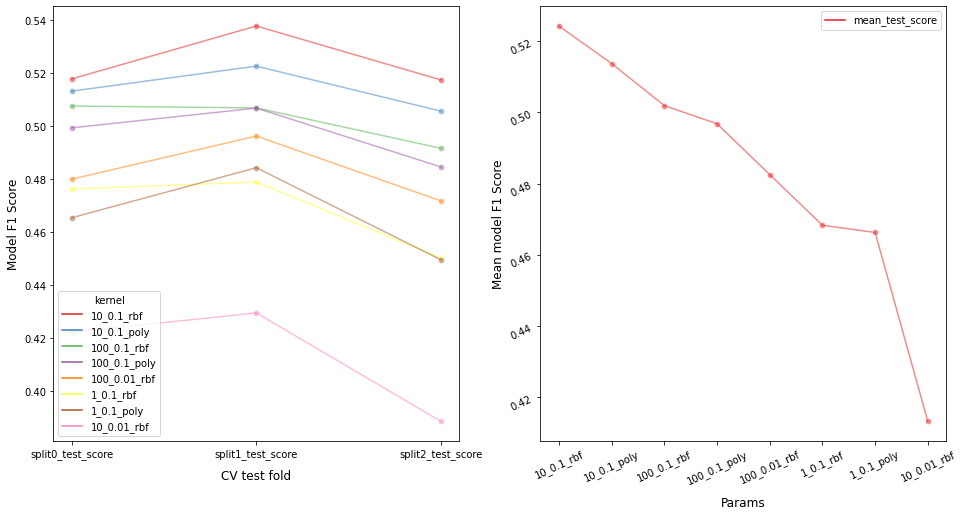

In [11]:
# plot result of grid search
result_df = visualize_cv(best_svc, 'F1', 8)

------SVM (Metric: f1)------
C           : 10
gamma.      : 0.1
kernel      : rbf
Test Results:
Accuracy : 0.8993696782041358
Precision: 0.43950850661625707
Recall   : 0.5946291560102301
MMC      : 0.45720739785018527
F1 score : 0.5054347826086956


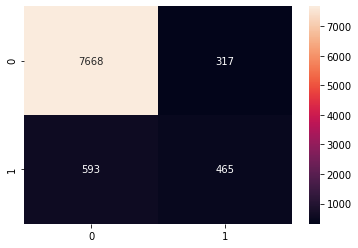

In [28]:
## test1: 10 0.1 'rbf' -- 0.550095

C_best = best_clf.best_params_['C']
gamma_best = best_clf.best_params_['max_iter']
kernel_best = best_clf.best_params_['solver']

SVC_best_model = best_svc.best_estimator_
y_pred = SVC_best_model.predict(x_test)

# print(metrics.f1_score(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
TP = cm[1,1]
FP = cm[1,0]
FN = cm[0,1]
TN = cm[0,0]
accuracy = (TP+TN)/np.sum(cm)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = (2 * precision * recall)/(precision + recall)

sns.heatmap(cm, annot=True, fmt="d")
print('------SVM (Metric: f1)------')
print(f'C           : {C_best}')
print(f'gamma.      : {gamma_best}')
print(f'kernel      : {kernel_best}')
print('Test Results:')
print(f'Accuracy : {accuracy}')
print(f'Precision: {precision}')
print(f'Recall   : {recall}')
print(f'MMC      : {matthews_corrcoef(y_test, y_pred)}')
print(f'F1 score : {F1}')

## Test with oversampling

In [11]:
## apply over-sampling
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=123)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

Note: the below grid search may take several hours! Use load functions below to load prepared 'best_svc_res' result.

In [13]:
## find best estimators on new training dataset
import warnings
warnings.filterwarnings("ignore")

params = {'kernel': ['rbf'], 
          'gamma' : [1e-1, 1e-2, 1e-3], 
          'C'     : [1e-2, 1e-1, 1, 10, 100]}

svc_res_test = SVC(probability=True) 
best_svc_res = GridSearchCV(svc_res_test, param_grid=params, cv=2, verbose=10, scoring='f1')
best_svc_res.fit(x_train_res,y_train_res)
best_svc_res.best_params_

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV 1/2; 1/15] START C=0.01, gamma=0.1, kernel=rbf..............................
[CV 1/2; 1/15] END C=0.01, gamma=0.1, kernel=rbf;, score=0.756 total time= 6.3min
[CV 2/2; 1/15] START C=0.01, gamma=0.1, kernel=rbf..............................
[CV 2/2; 1/15] END C=0.01, gamma=0.1, kernel=rbf;, score=0.909 total time= 8.7min
[CV 1/2; 2/15] START C=0.01, gamma=0.01, kernel=rbf.............................
[CV 1/2; 2/15] END C=0.01, gamma=0.01, kernel=rbf;, score=0.748 total time= 7.5min
[CV 2/2; 2/15] START C=0.01, gamma=0.01, kernel=rbf.............................
[CV 2/2; 2/15] END C=0.01, gamma=0.01, kernel=rbf;, score=0.899 total time=11.2min
[CV 1/2; 3/15] START C=0.01, gamma=0.001, kernel=rbf............................
[CV 1/2; 3/15] END C=0.01, gamma=0.001, kernel=rbf;, score=0.649 total time=13.0min
[CV 2/2; 3/15] START C=0.01, gamma=0.001, kernel=rbf............................
[CV 2/2; 3/15] END C=0.01, gamma=0.001,

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Only use "load" for loading pre-saved results

In [22]:
import pickle
# save & reload grid search results:
# res_model = {'model': best_svc_res}

# save 
# with open('svc_res.pickle', 'wb') as handle:
#     pickle.dump(res_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load
# with open('svc_res.pickle', 'rb') as handle:
#     res_model = pickle.load(handle)
    
# best_svc_res = res_model['model']
# print(best_svc_res.best_params_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


               mean_test_score
kernel                        
10_0.001_rbf          0.848101
1_0.01_rbf            0.847291
100_0.001_rbf         0.846910
1_0.001_rbf           0.841180
0.1_0.01_rbf          0.840577
10_0.01_rbf           0.836052
0.01_0.1_rbf          0.832225
0.1_0.1_rbf           0.831843


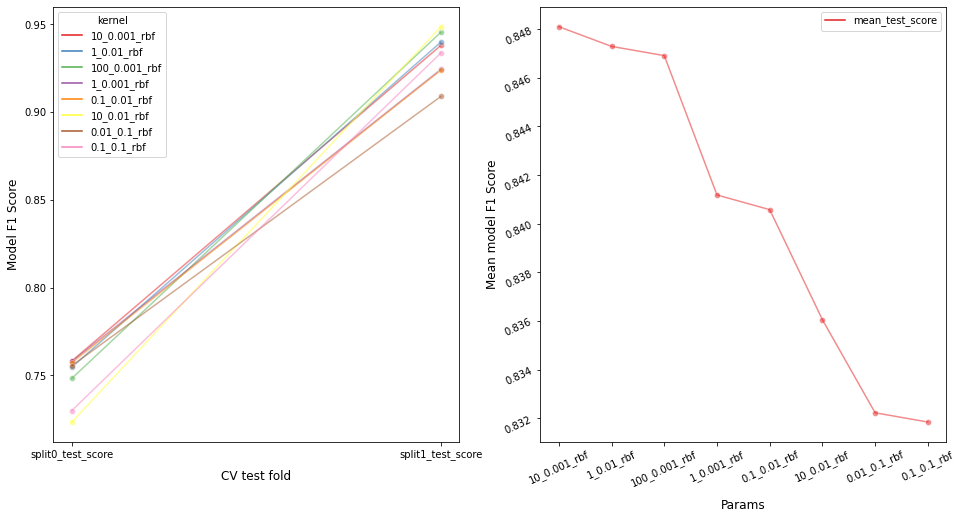

In [23]:
# plot results
result_df = visualize_cv(best_svc_res, 'F1', 8)

------SVM (Metric: f1)------
C           : 10
gamma.      : 0.001
kernel      : rbf
Test Results:
Accuracy : 0.8795753621585757
Precision: 0.7088846880907372
Recall   : 0.48987589810581317
MMC      : 0.5237334923549558
F1 score : 0.5793742757821552


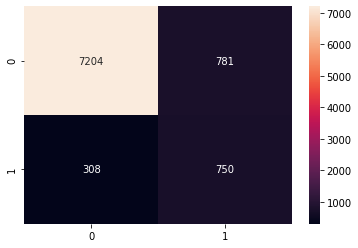

In [25]:
## test: 10 0.001 'rbf' -- 0.579374

C_best = best_clf.best_params_['C']
gamma_best = best_clf.best_params_['max_iter']
kernel_best = best_clf.best_params_['solver']

SVC_best_model = best_svc_res.best_estimator_
y_pred = SVC_best_model.predict(x_test)

# print(metrics.f1_score(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
TP = cm[1,1]
FP = cm[1,0]
FN = cm[0,1]
TN = cm[0,0]
accuracy = (TP+TN)/np.sum(cm)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = (2 * precision * recall)/(precision + recall)

sns.heatmap(cm, annot=True, fmt="d")
print('------SVM (Metric: f1)------')
print(f'C           : {C_best}')
print(f'gamma.      : {gamma_best}')
print(f'kernel      : {kernel_best}')
print('Test Results:')
print(f'Accuracy : {accuracy}')
print(f'Precision: {precision}')
print(f'Recall   : {recall}')
print(f'MMC      : {matthews_corrcoef(y_test, y_pred)}')
print(f'F1 score : {F1}')